In [151]:
import copy
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from numba import float32, float64, jit, NumbaPerformanceWarning
import warnings
import os
import yaml

warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

from utils import simulate_onestep_campi_example_1

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

from dataset_simple_example_1 import SimpleExample1Dataset

In [152]:
from pathlib import Path
import time
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformer_onestep import GPTConfig, GPT
import tqdm
import argparse
import metrics

In [153]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [154]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(420)
np.random.seed(430)
system_seed = 430 # Controls the system generation
data_seed = 0 # Control the input generation

In [155]:
# Overall settings
out_dir = "../out"

# System settings
nu = 1
ny = 1
#seq_len = 600
batch_size = 50 # 256

# Compute settings
cuda_device = "cuda:1"
no_cuda = True
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

In [156]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/"ckpt_controller_simple_example_1.61.pt", map_location=device)

In [157]:
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx

In [158]:
# del exp_data["model_args"]['use_pi']

In [159]:
model_args = exp_data["model_args"]
model_args['use_p'] = True
model_args['use_i'] = True
model_args['use_d'] = True
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict);

number of parameters: 0.46M


In [160]:
import pickle as pkl

with open('../../data/control/test_set_simple_example_1_0%_perturbation.pkl', 'rb') as f:
    test_set = pkl.load(f)

data_test = test_set['data_test']

In [161]:
# from control.matlab import *
# generate_from_model = True
# 
# if generate_from_model:
#     dtype="float32"
#     n_context = 300
#     
#     ts = 1e-2; fs = 1/ts
#     s = tf('s')
#     z = tf([1, 0], [1], dt=ts)
#     
#     # VRFT
#     s = tf('s')
#     tau = 1 # s
#     M = 1/(1 + (tau/(2*np.pi))*s)
#     M = c2d(M, ts, 'tustin')
#     
#     # Specifics for OL experiment
#     T = 20
#     t_exp = np.arange(0, T, ts)
#     t = np.arange(0, n_context*ts, ts)
#     
#     # To store results
#     U = np.zeros((len(data_test), n_context))
#     Y = np.zeros((len(data_test), n_context))
#     Y_d = np.zeros((len(data_test), n_context))
#     E = np.zeros((len(data_test), n_context))
#     R = np.zeros((len(data_test), n_context))
#     
#     for i, data in enumerate(data_test):
#         
#         num = [data['num_1']]
#         den = [data['den_1'], data['den_2'], data['den_3']]
#     
#         G_continuous = tf(num,den)
#         G = c2d(G_continuous, ts, 'tustin')
#         
#         u = np.random.normal(0, 1000, t_exp.shape)
#         y = lsim(G, u, t_exp)[0]
#     
#         u_L = lsim(M, u, t_exp)[0]
#         y_L = lsim(M, y, t_exp)[0]
#         r_v = lsim(M**(-1), y_L, t_exp)[0]
#         e_v = (r_v - y_L)
#     
#         u_L = u_L
#     
#         # normalize
#         e_v = e_v / 5#2.22  # mean 0, std 10
#         u_L = u_L / 177#62.3#118.5  # mean 0, std 17
#     
#     
#         e_v = e_v[1:]
#         u_L = u_L[:-1]
#         y_L = y_L[1:]
#         r_v = r_v[1:]
#         
#         # lunghezza contesto 5
#         # start_idx = np.random.randint(500, len(e_v)-n_context)
#         start_idx = 0
#         e_v = e_v[start_idx:start_idx + n_context] # this is e(t), ... e(t+N)
#         u_L = u_L[start_idx:start_idx + n_context] # this is u(t-1), ... u(t+N-1)
#         y_L = y_L[start_idx:start_idx + n_context] # this is u(t-1), ... u(t+N-1)
#         r_v = r_v[start_idx:start_idx + n_context]
#         
#         E[i,:] = e_v
#         U[i,:] = u_L
#         
#         Y[i,:] = y_L
#         R[i,:] = r_v
#         Y_d[i,:] = lsim(M, r_v, t)[0]
#         
#     t_CL = t
#     r_batch = R
#     
# else:
#     ts = 1e-2
#     T = 20#5#seq_len*ts
#     t_CL = np.arange(0, T, ts)
#     r_batch = np.zeros((batch_size, len(t_CL)))
#     r = np.zeros(t_CL.shape)
#     r[t_CL < 20] = 10
#     r[(t_CL >= 2.5) & (t_CL < 5)] = -10
#     r[(t_CL >= 5.0) & (t_CL < 7.5)] = 0
#     r[(t_CL >= 7.5) & (t_CL < 10)] = 5
#     r[(t_CL >= 10.) & (t_CL < 12.5)] = -5
#     r[(t_CL >= 12.5) & (t_CL < 15.)] = 20
#     r[(t_CL >= 15.0) & (t_CL < 17.5)] = 0
#     r[(t_CL >= 17.5) & (t_CL < 20.0)] = -20
#     
#     for i in range(r_batch.shape[0]):
#         # get virtual error
#         r_batch[i,:] = r

In [162]:
from control.matlab import *
# Generate the reference
generate_from_model = False
ts = 1e-2
T = 20#5#seq_len*ts
t_CL = np.arange(0, T, ts)
r_batch = np.zeros((batch_size, len(t_CL)))

if generate_from_model:
    test_ds = SimpleExample1Dataset(seq_len=len(t_CL), normalize=True, signal='white noise', use_prefilter=True, noisy=False)
    test_dl = DataLoader(test_ds, batch_size=batch_size)
    batch_u, batch_e, batch_r = next(iter(test_dl))
    for i in range(r_batch.shape[0]):
        # get virtual error
        r_batch[i,:] = batch_r[i,:,0]
else:
    r = 10*np.ones(t_CL.shape)
    # r[t_CL < 1] = -5
    # r[(t_CL >= 1) & (t_CL < 2)] = 5
    # r[(t_CL >= 2) & (t_CL < 3)] = 0
    r[(t_CL >= 2.5) & (t_CL < 5)] = -10
    r[(t_CL >= 5.0) & (t_CL < 7.5)] = 0
    r[(t_CL >= 7.5) & (t_CL < 10)] = 5
    r[(t_CL >= 10.) & (t_CL < 12.5)] = -5
    r[(t_CL >= 12.5) & (t_CL < 15.)] = 20
    r[(t_CL >= 15.0) & (t_CL < 17.5)] = 0
    r[(t_CL >= 17.5) & (t_CL < 20.0)] = -20
    for i in range(r_batch.shape[0]):
        # get virtual error
        r_batch[i,:] = r

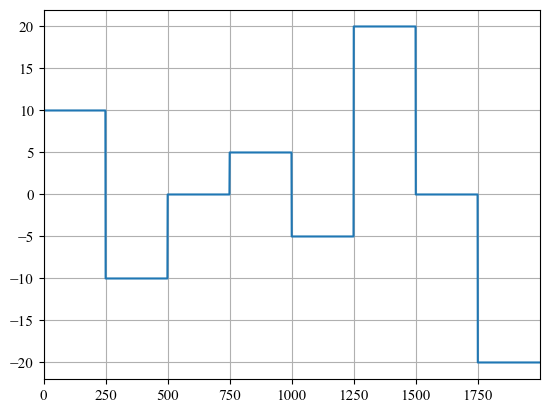

In [163]:
plt.plot(r_batch[0,:])

In [164]:
with open('normalization_params.yaml', 'r') as file:
    config = yaml.safe_load(file)
    
prefilter_key = 'prefilter'
signal_key = 'white noise'
signal_config = config.get(signal_key, {}).get(prefilter_key, {})
e_std = signal_config.get('e_std')
u_std = signal_config.get('u_std')

In [165]:
print(e_std)
print(u_std)

5
177


In [166]:
print(model.proportional_coefficient)
print(model.integral_coefficient)
print(model.derivative_coefficient)

Parameter containing:
tensor([2.5652], requires_grad=True)
Parameter containing:
tensor([6.9580e-05], requires_grad=True)
Parameter containing:
tensor([0.5701], requires_grad=True)


In [167]:
import copy
n_testing = 0
H = 300

y_d = np.empty((len(data_test),len(t_CL)))
y_log = np.empty((len(data_test),len(t_CL)))
e_log = np.empty((len(data_test),len(t_CL)))
u_log = np.empty((len(data_test),len(t_CL)))

Ts = 1e-2; Fs = 1 / Ts
s = tf('s')

# problem data

# (e_t, u_{t-1}) -> Transformer -> u_t

# x(0), u(-1) = 0, y(0), e(0) = r(0) - y(0)
# VRFT
s = tf('s')
tau = 1 # s
M = 1/(1 + (tau/(2*np.pi))*s)
M = c2d(M, ts, 'tustin')

with torch.no_grad():
    for n_testing in range(1):#len(data_test)):
        
        print(n_testing)
        
        # print(n_testing)
        
        # e = torch.Tensor([[[]]])
        # e_int = torch.Tensor([[[]]])
        # u = torch.Tensor([[[]]])
        e = np.array([])
        # e_int = np.array([])
        u = np.array([])
        
        # This is like t=0, for our model we need u(-1).
        x_i = np.array([[0, 0]]) # x(0)
        y_i = x_i[:,1]    # y(0)
        u_prev = 0 # u(-1)

        data = data_test[n_testing]
        # system
        num = [data['num_1']]
        den = [data['den_1'], data['den_2'], data['den_3']]
        P = tf(num, den)
        
        for i in range(0,len(t_CL)):#batch_u.shape[0]): # for each system
            
            y_d[n_testing,:] = lsim(M, r_batch[n_testing,:], t_CL)[0]
            
            # print(i)
            # if i == 6:
            #     print('e:', e[0, 0, :5])
            #     print('u:', u[0, 0, :5])
            #     print('u_hat:', pred[0, :5, 0])
            #     print('y:', y_log[0, :5])
            #     print('x:', x_i)

            e_i_model = r_batch[n_testing,i] - y_i # e(t)
            e_i = e_i_model / e_std#batch_e[n_testing,i,0]
            
            y_log[n_testing,i] = y_i
            e_log[n_testing,i] = e_i_model
            
            # if i == 0:
            #     e_int_i = e_i
            # else:
            #     e_int_i = np.cumsum(e_log[n_testing,:].flatten())[-1] + e_i
                
            e = np.hstack((e, e_i))#4.8320))
            # e_int = np.hstack((e_int, e_int_i / 70))
            u = np.hstack((u, u_prev / u_std))#175.1))
            
            # Convert to torch.Tensor just before feeding to model
            e_tensor = torch.tensor(e, dtype=torch.float32).reshape(1, -1, 1)
            u_tensor = torch.tensor(u, dtype=torch.float32).reshape(1, -1, 1)
    

            # # print(e_i.shape)
            # e = torch.cat((e, copy.deepcopy(e_i)), 2)    #  e(0), ..., e(t)
            # e_int = torch.cat((e_int, copy.deepcopy(e_int_i) / 70), 2)    #  e(0), ..., e(t)
            # u = torch.cat((u, copy.deepcopy(u_prev) / 118.5), 2) # u(-1), ..., u(t-1)
            # 
            
            # Controller u(t) = C(e(t),u(t-1))
            if i < H:
                pred, _ = model(e_tensor, u_tensor)
            else:
                pred, _ = model(e_tensor[:, -H:, :], u_tensor[:, -H:, :])
            # print(pred.shape)
    
            u_i_model = pred[:,-1,:].item() * u_std # u(t)
            u_i = u_i_model#batch_u[n_testing,i+1,0] * u_std
            u_log[n_testing,i] = u_i_model
    
            # simulation
            y_i, t_out, x_i = lsim(P, u_i, np.array([0, Ts]), x_i[-1], return_x=True)
            y_i = y_i[-1]  # y(t) <- y(t+1)
            u_prev = u_i#u_i # u(t-1)

0


/tmp/ipykernel_4130253/1670383503.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_log[n_testing,i] = y_i
/tmp/ipykernel_4130253/1670383503.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  e_log[n_testing,i] = e_i_model
/home/rbusetto/.virtualenvs/sysid-transformers-control/lib/python3.10/site-packages/control/timeresp.py:1003: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
/home/rbusetto/.virtualenvs/sysid-transformers-control/lib/python3.10/site-packages/control/timeresp.py:1009: UserWarning: Non-zero initial condition given for

In [168]:
# print('e:', e_tensor[0, :5, 0])
# print('u:', u_tensor[0, :5, 0])
# print('u:', u_log[0, :5]/175.1)
# # print('u_hat:', batch_u_pred[0, :5, 0])
# print('y:', y_log[0, :5])
# print('r:', r_batch[0, :5])

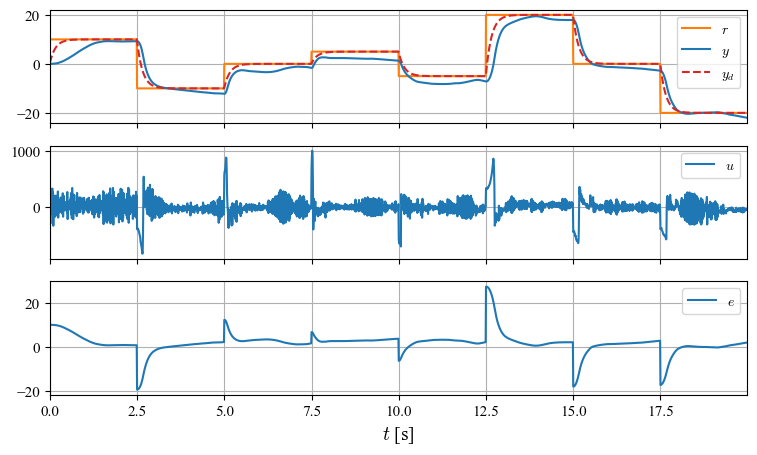

In [169]:
fig = plt.figure(figsize=(9, 5))
ax1 = plt.subplot(311)
#plt.plot(t_CL, r)
plt.plot(t_CL, r_batch[n_testing,:], label="$r$", c='tab:orange')
plt.plot(t_CL, y_log[0,:].T, label="$y$", c='tab:blue', alpha=1)
plt.plot(t_CL, y_d[0,:].T, label="$y_d$", c='tab:red', alpha=1, linestyle='--')
plt.legend(['$r$','$y$','$y_d$'])
# plt.xlim([0, 0.43])
# plt.ylim([0, 10])
plt.tick_params('x', labelbottom=False)

ax2 = plt.subplot(312, sharex=ax1)
plt.plot(t_CL, u_log[0,:].T, c='tab:blue', alpha=1)
# plt.plot(t_CL[:-1], batch_u[0,1:,0] * u_std, c='tab:green', alpha=1)
plt.legend(['$u$', '$u_{ideal}$'])
# plt.xlim([10, 12])
plt.tick_params('x', labelbottom=False)

ax3 = plt.subplot(313, sharex=ax1)
plt.plot(t_CL[:-1], e_log[0,:-1], c='tab:blue', alpha=1)
# plt.plot(t_CL, batch_e[0,:,0] * e_std, c='tab:green', alpha=1)
plt.xlabel('$t$ [s]')
# plt.ylim([0, 4])
plt.legend(['$e$', '$e_{ideal}$'])

# plt.savefig('transformer_controller.pdf')

plt.show()

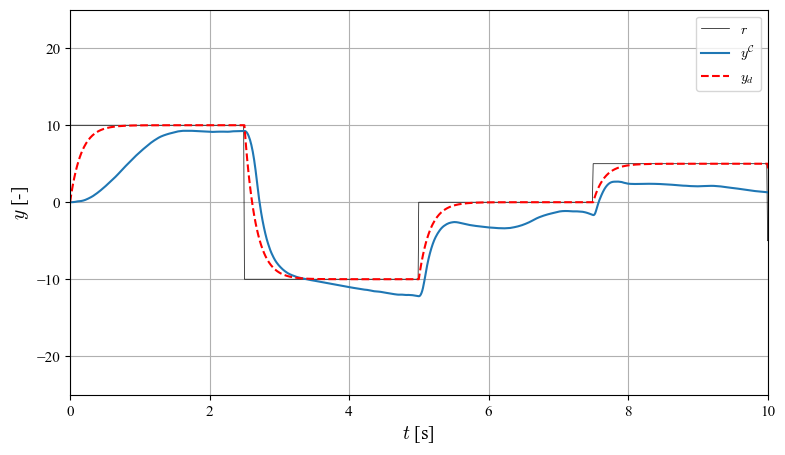

In [170]:
s = tf('s')
tau = 1 # s
M = 1/(1 + (tau/(2*np.pi))*s)
M = c2d(M, ts, 'matched')

y_d = lsim(M, r, t_CL, return_x=False)[0]

fig = plt.figure(figsize=(9, 5))
plt.plot(t_CL, r_batch[n_testing,:], color='k', linewidth=0.5, label='$r$')
plt.plot(t_CL, y_log[0,:].T, label=r'$y^{\mathcal{C}}$')
plt.plot(t_CL, y_d, color='r', linestyle='--', label='$y_d$')
plt.xlabel("$t$ [s]")
plt.ylabel("$y$ [-]")
plt.xlim([0, 10])
plt.ylim([-25, 25])
plt.legend()
plt.margins(x=0)
plt.show()